<a href="https://colab.research.google.com/github/SangminAhn21/DL_Study/blob/main/Kaggle/Facial_Keypoint_Detection/Facial_Keypoint_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [22]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

In [4]:
pip install kaggle

In [5]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  
# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 66 bytes


In [6]:
!kaggle competitions download -c facial-keypoints-detection

 92% 55.0M/60.1M [00:01<00:00, 36.2MB/s]
100% 60.1M/60.1M [00:01<00:00, 56.5MB/s]
  0% 0.00/843k [00:00<?, ?B/s]
100% 843k/843k [00:00<00:00, 26.5MB/s]
 56% 9.00M/16.0M [00:00<00:00, 9.88MB/s]
100% 16.0M/16.0M [00:00<00:00, 19.4MB/s]
  0% 0.00/201k [00:00<?, ?B/s]
100% 201k/201k [00:00<00:00, 66.1MB/s]


In [7]:
IdLookupTable = pd.read_csv('IdLookupTable.csv')

In [8]:
IdLookupTable

,RowId,ImageId,FeatureName,Location
0,1,1,left_eye_center_x,NaN
1,2,1,left_eye_center_y,NaN
2,3,1,right_eye_center_x,NaN
3,4,1,right_eye_center_y,NaN
4,5,1,left_eye_inner_corner_x,NaN
...,...,...,...,...
27119,27120,1783,right_eye_center_y,NaN
27120,27121,1783,nose_tip_x,NaN
27121,27122,1783,nose_tip_y,NaN
27122,27123,1783,mouth_center_bottom_lip_x,NaN


In [9]:
SampleSubmission = pd.read_csv('SampleSubmission.csv')
SampleSubmission

,RowId,Location
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0
...,...,...
27119,27120,0
27120,27121,0
27121,27122,0
27122,27123,0


In [10]:
!unzip ../content/training.zip
!unzip ../content/test.zip

Archive:  ../content/training.zip
  inflating: training.csv            
Archive:  ../content/test.zip
  inflating: test.csv                


In [11]:
training_pd = pd.read_csv('training.csv')
test_pd = pd.read_csv('test.csv')

In [ ]:
training_pd.head()

In [12]:
training_pd.isnull().sum()

left_eye_center_x              10
left_eye_center_y              10
right_eye_center_x             13
right_eye_center_y             13
left_eye_inner_corner_x      4778
left_eye_inner_corner_y      4778
left_eye_outer_corner_x      4782
left_eye_outer_corner_y      4782
right_eye_inner_corner_x     4781
right_eye_inner_corner_y     4781
right_eye_outer_corner_x     4781
right_eye_outer_corner_y     4781
left_eyebrow_inner_end_x     4779
left_eyebrow_inner_end_y     4779
left_eyebrow_outer_end_x     4824
left_eyebrow_outer_end_y     4824
right_eyebrow_inner_end_x    4779
right_eyebrow_inner_end_y    4779
right_eyebrow_outer_end_x    4813
right_eyebrow_outer_end_y    4813
nose_tip_x                      0
nose_tip_y                      0
mouth_left_corner_x          4780
mouth_left_corner_y          4780
mouth_right_corner_x         4779
mouth_right_corner_y         4779
mouth_center_top_lip_x       4774
mouth_center_top_lip_y       4774
mouth_center_bottom_lip_x      33
mouth_center_b

In [13]:
training_pd = training_pd.fillna(method='ffill')

In [14]:
training = training_pd.to_numpy()
test = test_pd.to_numpy()

In [15]:
print(training.shape)
print(test.shape)

(7049, 31)
(1783, 2)


In [39]:
train_image = training[:, -1]
train_key = training[:, :-1].astype('float64')
test_image = test[:, 1]
print(train_image.shape)
print(train_key.shape)
print(test_image.shape)

(7049,)
(7049, 30)
(1783,)


In [40]:
train_image = np.array([np.array([int(pixel) for pixel in image.split()]).reshape(96, 96) for image in train_image])
test_image = np.array([np.array([int(pixel) for pixel in image.split()]).reshape(96, 96) for image in test_image])

In [41]:
print(train_image.shape)
print(test_image.shape)

(7049, 96, 96)
(1783, 96, 96)


In [42]:
def plot_sample(image, keypoint, axis, title):
    image = image.reshape(96,96)
    axis.imshow(image, cmap='gray')
    axis.scatter(keypoint[0::2], keypoint[1::2], marker='x', s=20)
    plt.title(title)

# from 'Facial Keypoint Detection - CNN + Augmentation' by Luong Quang Dung

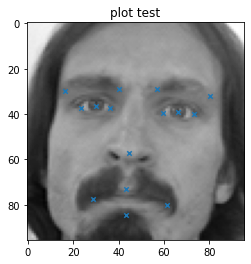

In [43]:
fig, axis = plt.subplots()
plot_sample(train_image[0], train_key[0], axis, 'plot test')

In [21]:
if torch.cuda.is_available():
  DEVICE = torch.device('cuda')
else:
  DEVICE = torch.device('cpu')

print('Using PyTorch version:', torch.__version__, ' Device: ', DEVICE)

Using PyTorch version: 1.9.0+cu111  Device:  cuda


In [45]:
class FaceDataset(Dataset):

    def __init__(self, x, y):
        self.len = x.shape[0]
        self.x_data = torch.from_numpy(x)
        self.y_data = torch.from_numpy(y)

    def __getitem__(self, index):
        return self.x_data[index], self.y_data[index]

    def __len__(self):
        return self.len


dataset = FaceDataset(train_image, train_key)
train_loader = DataLoader(dataset=dataset,
                          batch_size=32,
                          shuffle=True)

In [46]:
for (x_train, y_train) in train_loader:
  print("x_train:", x_train.size(), 'type:', x_train.type())
  print("y_train:", y_train.size(), 'type:', y_train.type())
  break

x_train: torch.Size([32, 96, 96]) type: torch.LongTensor
y_train: torch.Size([32, 30]) type: torch.DoubleTensor
